# Introduction - Image-to-Image Change Detection

Change detection is a *hot* topic within the Earth Observation (EO) community, particular since the release of the landsat archive and more recently the availablity of the  ESA Sentinel-1 and 2 data.

There are several approaches to change detection and these can be categorised as:

- Map-to-Map
- Image-to-Image
- Map-to-Image
- Dense Timeseries

These approaches have different advances and disadvantages and this tutorial will demonstrate the implementation of a method for each type.

## What is Image-to-Image Change?

Image-to-Image change detection processes compare the pixel values of two (or more) EO image datasets and if those values are different then a change occurs. These algorithms are **sensitive to seasonal, geometry and modality changes** which can result is false positives. However, these methods are useful as they are **quick to implement**  and **don't require background knowledge** on the land covers or make you decided on a particular key. The simiplest approach for such methods is to take a simple difference between two image bands or derived indices (e.g., NDVI).

## What are the steps:

This is quite a simple method, basically just take the difference between the images. In this notebook we will go through the process of using a different and ratio to perform an image-to-image change detection.



# 1. Define Imports

In [1]:
import os
import shutil
import rsgislib
import rsgislib.imagecalc
import rsgislib.imagecalc.calcindices
import rsgislib.imageutils
import rsgislib.rastergis


# Imports for data visualisation
import rsgislib.tools.plotting
# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# 2. Define Input Images

In [2]:
cls_2018_dir = "2018_cls"
if not os.path.exists(cls_2018_dir):
    os.mkdir(cls_2018_dir)

cls_1997_dir = "baseline_cls"
if not os.path.exists(cls_1997_dir):
    os.mkdir(cls_1997_dir)

img_to_img_chg_dir = "img_to_img_chg"
if not os.path.exists(img_to_img_chg_dir):
    os.mkdir(img_to_img_chg_dir)


# File path to the 1997 classification
cls_1997_img = os.path.join(cls_1997_dir, "base_1997_class_img.kea")

# File path to the input Landsat 5 image from 1997.
input_97_img = (
    "../data/chg_data/LS5TM_19970716_vmsk_mclds_topshad_rad_srefdem_stdsref_subset.tif"
)

# File path to the Landsat 5 valid data mask from 1997
vld_97_img = os.path.join(cls_1997_dir, "LS5TM_19970716_vmsk.kea")


# File path to the input Landsat 8 image from 2018.
input_18_img = (
    "../data/chg_data/LS8_20180608_vmsk_mclds_topshad_rad_srefdem_stdsref_subset.tif"
)

# File path to the Landsat 8 valid data mask from 2018.
vld_18_img = os.path.join(cls_2018_dir, "LS8_20180608_vmsk.kea")

# 3. Calculate NDVI and WBI

For this notebook we will use the NDVI index to define the change between the two images.

In [4]:
ls_1997_ndvi_img = os.path.join(img_to_img_chg_dir, "LS5TM_19970716_ndvi.kea")
rsgislib.imagecalc.calcindices.calc_ndvi(input_97_img, 3, 4, ls_1997_ndvi_img)

ls_2018_ndvi_img = os.path.join(img_to_img_chg_dir, "LS8_20180608_ndvi.kea")
rsgislib.imagecalc.calcindices.calc_ndvi(input_18_img, 4, 5, ls_2018_ndvi_img)

ls_2018_wbi_img = os.path.join(img_to_img_chg_dir, "LS8_20180608_wbi.kea")
rsgislib.imagecalc.calcindices.calc_wbi(input_18_img, 2, 5, ls_2018_wbi_img)

Image: ../data/chg_data/LS5TM_19970716_vmsk_mclds_topshad_rad_srefdem_stdsref_subset.tif
	 Variable 'red' is band 3
	 Variable 'nir' is band 4
New image width = 1281 height = 3659 bands = 1



Calculating Image Pyramids.

Image: ../data/chg_data/LS8_20180608_vmsk_mclds_topshad_rad_srefdem_stdsref_subset.tif
	 Variable 'red' is band 4
	 Variable 'nir' is band 5
New image width = 1281 height = 3659 bands = 1



Calculating Image Pyramids.

Image: ../data/chg_data/LS8_20180608_vmsk_mclds_topshad_rad_srefdem_stdsref_subset.tif
	 Variable 'blue' is band 2
	 Variable 'nir' is band 5
New image width = 1281 height = 3659 bands = 1



Calculating Image Pyramids.



# 4. Image to Image Difference Change

## 4.1 Calculate NDVI Difference

Note, this needs to be for regions which are valid in both images.

In [5]:
ndvi_diff_img = os.path.join(img_to_img_chg_dir, "ndvi_diff_1997_2018.kea")

band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("vld_97_msk", vld_97_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("vld_18_msk", vld_18_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("ndvi_97", ls_1997_ndvi_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("ndvi_18", ls_2018_ndvi_img, 1))

exp = "(vld_18_msk==1)&&(vld_97_msk==1)?ndvi_97-ndvi_18:0"

rsgislib.imagecalc.band_math(
    ndvi_diff_img, exp, "KEA", rsgislib.TYPE_32FLOAT, band_defns
)

rsgislib.imageutils.pop_img_stats(
    ndvi_diff_img, use_no_data=True, no_data_val=0, calc_pyramids=True
)

Image: 2018_cls/LS8_20180608_vmsk.kea
	 Variable 'vld_18_msk' is band 1
Image: baseline_cls/LS5TM_19970716_vmsk.kea
	 Variable 'vld_97_msk' is band 1
Image: img_to_img_chg/LS5TM_19970716_ndvi.kea
	 Variable 'ndvi_97' is band 1
Image: img_to_img_chg/LS8_20180608_ndvi.kea
	 Variable 'ndvi_18' is band 1
New image width = 1281 height = 3659 bands = 1



Calculating Image Pyramids.



## 4.2 Visualise NDVI Different Image

Image Data Size: 900 x 767


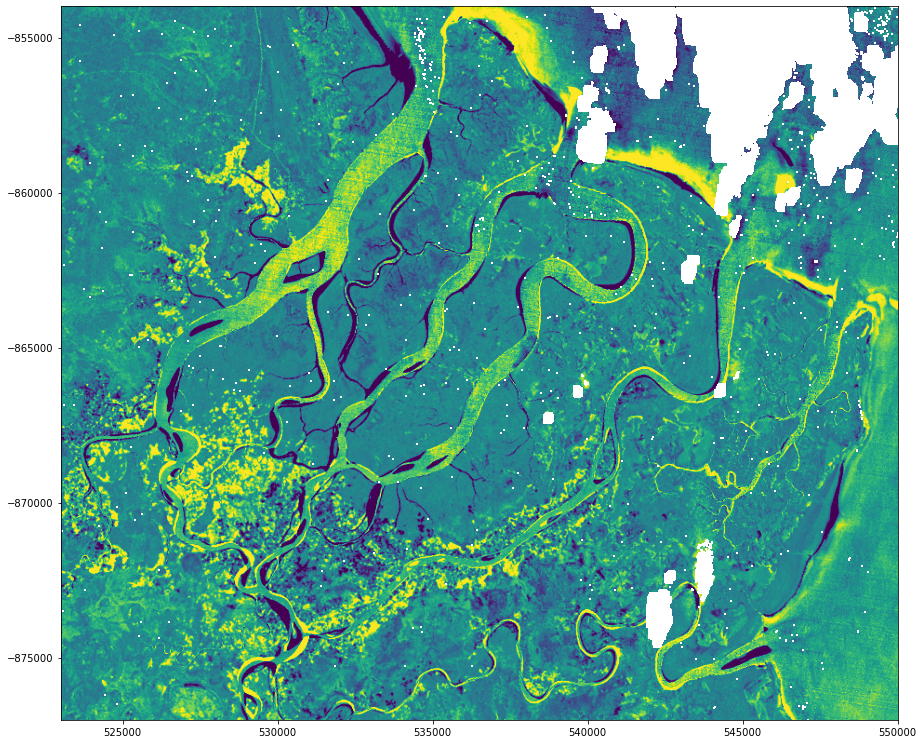

In [6]:
sub_bbox = [523000, 550000, -877000, -854000]

img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    ndvi_diff_img, bbox=sub_bbox
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)


# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 15))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(img_data_strch, extent=img_coords)

## 4.3 Update 1997 Classification to 2018

In [7]:
chng_diff_2018_cls_img = os.path.join(img_to_img_chg_dir, "chng_map_diff_2018_img2img.kea")

band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("vld_18_msk", vld_18_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("cls_1997", cls_1997_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("ndvi_diff", ndvi_diff_img, 1))
exp = """(vld_18_msk==1)&&(cls_1997==1)&&(ndvi_diff<0.35)&&(ndvi_diff>-0.35)?1:
         (vld_18_msk==1)&&(cls_1997==1)&&(ndvi_diff>0.35)?2:
         (vld_18_msk==1)&&(cls_1997==1)?1:
         (vld_18_msk==1)&&(cls_1997==2)?2:
         (vld_18_msk==1)&&(cls_1997==3)&&(ndvi_diff<-0.35)?1:
         (vld_18_msk==1)&&(cls_1997==3)?3:0
      """
rsgislib.imagecalc.band_math(
    chng_diff_2018_cls_img, exp, "KEA", rsgislib.TYPE_8UINT, band_defns
)
rsgislib.rastergis.pop_rat_img_stats(
    chng_diff_2018_cls_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)


Image: 2018_cls/LS8_20180608_vmsk.kea
	 Variable 'vld_18_msk' is band 1
Image: baseline_cls/base_1997_class_img.kea
	 Variable 'cls_1997' is band 1
Image: img_to_img_chg/ndvi_diff_1997_2018.kea
	 Variable 'ndvi_diff' is band 1
New image width = 1281 height = 3659 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 4.4 Create Change Image

In [8]:
# Define output image path
chng_map_diff_img = os.path.join(img_to_img_chg_dir, "chng_map_1997_2018_diff_img2img.kea")

# Define the input image bands
band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("cls_1997", cls_1997_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("cls_2018", chng_diff_2018_cls_img, 1))

# Expression to define change classes
exp = """(cls_1997==1)&&(cls_2018==1)?11:
         (cls_1997==1)&&(cls_2018==2)?12:
         (cls_1997==1)&&(cls_2018==3)?13:
         (cls_1997==2)&&(cls_2018==1)?21:
         (cls_1997==2)&&(cls_2018==2)?22:
         (cls_1997==2)&&(cls_2018==3)?23:
         (cls_1997==3)&&(cls_2018==1)?31:
         (cls_1997==3)&&(cls_2018==2)?32:
         (cls_1997==3)&&(cls_2018==3)?33:0
      """

# Run band_math
rsgislib.imagecalc.band_math(chng_map_diff_img, exp, "KEA", rsgislib.TYPE_8UINT, band_defns)

# Populate stats and pyramids
rsgislib.rastergis.pop_rat_img_stats(
    chng_map_diff_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

Image: baseline_cls/base_1997_class_img.kea
	 Variable 'cls_1997' is band 1
Image: img_to_img_chg/chng_map_diff_2018_img2img.kea
	 Variable 'cls_2018' is band 1
New image width = 1281 height = 3659 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 4.5 Colour and Name Change Classes

In [9]:
class_info_dict = dict()
class_info_dict[11] = {
    "classname": "Mangrove_Mangrove",
    "red": 25,
    "green": 200,
    "blue": 25,
}
class_info_dict[12] = {
    "classname": "Mangrove_Terrestrial",
    "red": 200,
    "green": 100,
    "blue": 25,
}
class_info_dict[13] = {
    "classname": "Mangrove_Water",
    "red": 200,
    "green": 25,
    "blue": 200,
}
class_info_dict[21] = {
    "classname": "Terrestrial_Mangrove",
    "red": 125,
    "green": 100,
    "blue": 125,
}
class_info_dict[22] = {
    "classname": "Terrestrial_Terrestrial",
    "red": 125,
    "green": 125,
    "blue": 125,
}
class_info_dict[23] = {
    "classname": "Terrestrial_Water",
    "red": 125,
    "green": 125,
    "blue": 100,
}
class_info_dict[31] = {
    "classname": "Water_Mangrove",
    "red": 25,
    "green": 255,
    "blue": 200,
}
class_info_dict[32] = {
    "classname": "Water_Terrestrial",
    "red": 62,
    "green": 62,
    "blue": 200,
}
class_info_dict[33] = {
    "classname": "Water_Water",
    "red": 25, 
    "green": 25,      
    "blue": 200
}

rsgislib.rastergis.set_class_names_colours(chng_map_diff_img, "class_names", class_info_dict)

## 4.6 Visualise the NDVI Difference Change Map

Image Data Size: 900 x 767


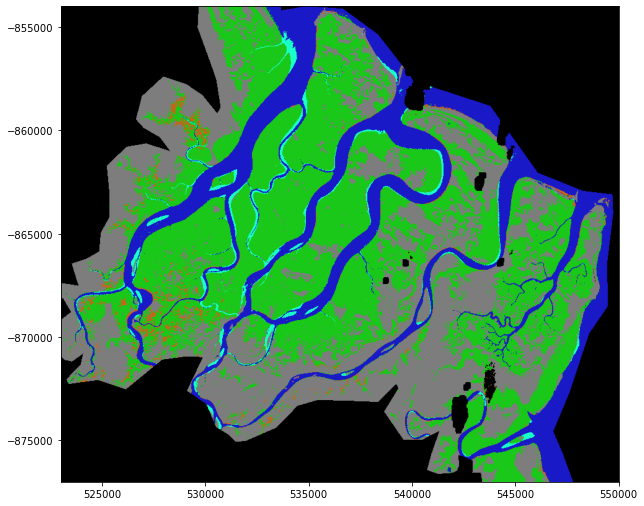

In [10]:
sub_bbox = [523000, 550000, -877000, -854000]

# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_msk_data,
    img_msk_coords,
    lgd_msk_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    chng_map_diff_img, bbox=sub_bbox
)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(img_msk_data, extent=img_msk_coords)

# 5. Image to Image Ratio Change

## 5.1 Calculate NDVI Ratio

In [11]:
ndvi_ratio_img = os.path.join(img_to_img_chg_dir, "ndvi_ratio_1997_2018.kea")

band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("vld_97_msk", vld_97_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("vld_18_msk", vld_18_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("ndvi_97", ls_1997_ndvi_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("ndvi_18", ls_2018_ndvi_img, 1))

exp = "(vld_18_msk==1)&&(vld_97_msk==1)?ndvi_97/ndvi_18:0"

rsgislib.imagecalc.band_math(
    ndvi_ratio_img, exp, "KEA", rsgislib.TYPE_32FLOAT, band_defns
)

rsgislib.imageutils.pop_img_stats(
    ndvi_ratio_img, use_no_data=True, no_data_val=0, calc_pyramids=True
)

Image: 2018_cls/LS8_20180608_vmsk.kea
	 Variable 'vld_18_msk' is band 1
Image: baseline_cls/LS5TM_19970716_vmsk.kea
	 Variable 'vld_97_msk' is band 1
Image: img_to_img_chg/LS5TM_19970716_ndvi.kea
	 Variable 'ndvi_97' is band 1
Image: img_to_img_chg/LS8_20180608_ndvi.kea
	 Variable 'ndvi_18' is band 1
New image width = 1281 height = 3659 bands = 1



Calculating Image Pyramids.



## 5.2 Visualise NDVI Ratio

Image Data Size: 900 x 767


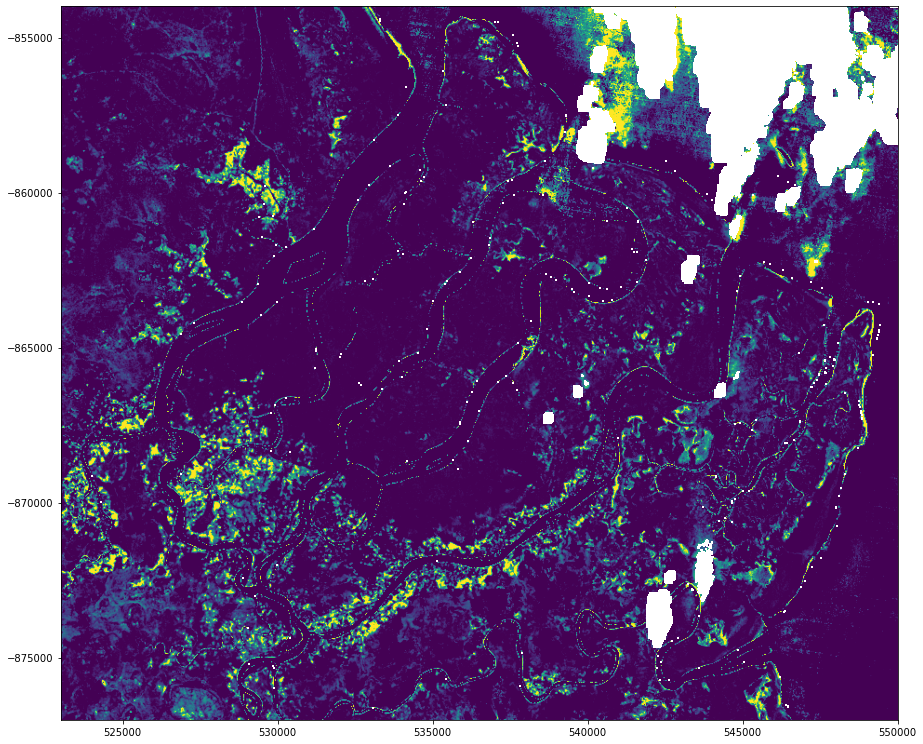

In [12]:
from strch_funcs import manual_stretch_np_arr

sub_bbox = [523000, 550000, -877000, -854000]

img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    ndvi_ratio_img, bbox=sub_bbox
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
min_max_vals = {"min":0.5, "max": 1.5}
#img_data_strch = rsgislib.tools.plotting.manual_stretch_np_arr(img_data, min_max_vals, no_data_val=0.0)
img_data_strch = manual_stretch_np_arr(img_data, min_max_vals, no_data_val=0.0)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(15, 15))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(img_data_strch, extent=img_coords)

## 5.3 Update 1997 Classification to 2018

In [13]:
chng_ratio_2018_cls_img = os.path.join(img_to_img_chg_dir, "chng_map_ratio_2018_img2img.kea")

band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("vld_18_msk", vld_18_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("cls_1997", cls_1997_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("ndvi_ratio", ndvi_ratio_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("wbi_18", ls_2018_wbi_img, 1))
exp = """(vld_18_msk==1)&&(cls_1997==1)&&(ndvi_ratio<1.3)&&(ndvi_ratio>0.7)?1:
         (vld_18_msk==1)&&(cls_1997==1)&&(ndvi_ratio>1.3)?2:
         (vld_18_msk==1)&&(cls_1997==1)?1:
         (vld_18_msk==1)&&(cls_1997==2)?2:
         (vld_18_msk==1)&&(cls_1997==3)&&(ndvi_ratio<0.1)&&(wbi_18<0.4)?1:
         (vld_18_msk==1)&&(cls_1997==3)?3:0
      """
rsgislib.imagecalc.band_math(
    chng_ratio_2018_cls_img, exp, "KEA", rsgislib.TYPE_8UINT, band_defns
)
rsgislib.rastergis.pop_rat_img_stats(
    chng_ratio_2018_cls_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)


Image: 2018_cls/LS8_20180608_vmsk.kea
	 Variable 'vld_18_msk' is band 1
Image: baseline_cls/base_1997_class_img.kea
	 Variable 'cls_1997' is band 1
Image: img_to_img_chg/LS8_20180608_wbi.kea
	 Variable 'wbi_18' is band 1
Image: img_to_img_chg/ndvi_ratio_1997_2018.kea
	 Variable 'ndvi_ratio' is band 1
New image width = 1281 height = 3659 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 5.4 Create Change Image

In [15]:
# Define output image path
chng_map_ratio_img = os.path.join(img_to_img_chg_dir, "chng_map_1997_2018_ratio_img2img.kea")

# Define the input image bands
band_defns = []
band_defns.append(rsgislib.imagecalc.BandDefn("cls_1997", cls_1997_img, 1))
band_defns.append(rsgislib.imagecalc.BandDefn("cls_2018", chng_ratio_2018_cls_img, 1))

# Expression to define change classes
exp = """(cls_1997==1)&&(cls_2018==1)?11:
         (cls_1997==1)&&(cls_2018==2)?12:
         (cls_1997==1)&&(cls_2018==3)?13:
         (cls_1997==2)&&(cls_2018==1)?21:
         (cls_1997==2)&&(cls_2018==2)?22:
         (cls_1997==2)&&(cls_2018==3)?23:
         (cls_1997==3)&&(cls_2018==1)?31:
         (cls_1997==3)&&(cls_2018==2)?32:
         (cls_1997==3)&&(cls_2018==3)?33:0
      """

# Run band_math
rsgislib.imagecalc.band_math(chng_map_ratio_img, exp, "KEA", rsgislib.TYPE_8UINT, band_defns)

# Populate stats and pyramids
rsgislib.rastergis.pop_rat_img_stats(
    chng_map_ratio_img, add_clr_tab=True, calc_pyramids=True, ignore_zero=True
)

Image: baseline_cls/base_1997_class_img.kea
	 Variable 'cls_1997' is band 1
Image: img_to_img_chg/chng_map_ratio_2018_img2img.kea
	 Variable 'cls_2018' is band 1
New image width = 1281 height = 3659 bands = 1

Get Image Min and Max.

Get Image Histogram.

Adding Histogram and Colour Table to image file
Calculating Image Pyramids.



## 5.5 Colour and Name Change Classes

In [16]:
class_info_dict = dict()
class_info_dict[11] = {
    "classname": "Mangrove_Mangrove",
    "red": 25,
    "green": 200,
    "blue": 25,
}
class_info_dict[12] = {
    "classname": "Mangrove_Terrestrial",
    "red": 200,
    "green": 100,
    "blue": 25,
}
class_info_dict[13] = {
    "classname": "Mangrove_Water",
    "red": 200,
    "green": 25,
    "blue": 200,
}
class_info_dict[21] = {
    "classname": "Terrestrial_Mangrove",
    "red": 125,
    "green": 100,
    "blue": 125,
}
class_info_dict[22] = {
    "classname": "Terrestrial_Terrestrial",
    "red": 125,
    "green": 125,
    "blue": 125,
}
class_info_dict[23] = {
    "classname": "Terrestrial_Water",
    "red": 125,
    "green": 125,
    "blue": 100,
}
class_info_dict[31] = {
    "classname": "Water_Mangrove",
    "red": 25,
    "green": 255,
    "blue": 200,
}
class_info_dict[32] = {
    "classname": "Water_Terrestrial",
    "red": 62,
    "green": 62,
    "blue": 200,
}
class_info_dict[33] = {
    "classname": "Water_Water",
    "red": 25, 
    "green": 25,      
    "blue": 200
}

rsgislib.rastergis.set_class_names_colours(chng_map_ratio_img, "class_names", class_info_dict)

## 5.6 Visualise the NDVI Ratio Change Map

Image Data Size: 900 x 767


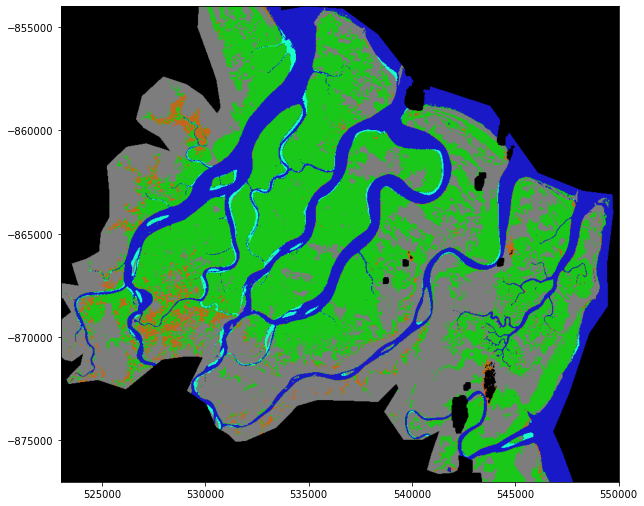

In [17]:
sub_bbox = [523000, 550000, -877000, -854000]

# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_msk_data,
    img_msk_coords,
    lgd_msk_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    chng_map_ratio_img, bbox=sub_bbox
)

# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Use the imshow function to display the image data within the plot
# the extent option defines the x and y axis values.
ax.imshow(img_msk_data, extent=img_msk_coords)

# 6. Compare Image-to-Image Results

Image Data Size: 900 x 767
Image Data Size: 900 x 767


Text(0.5, 1.0, 'Ratio Change')

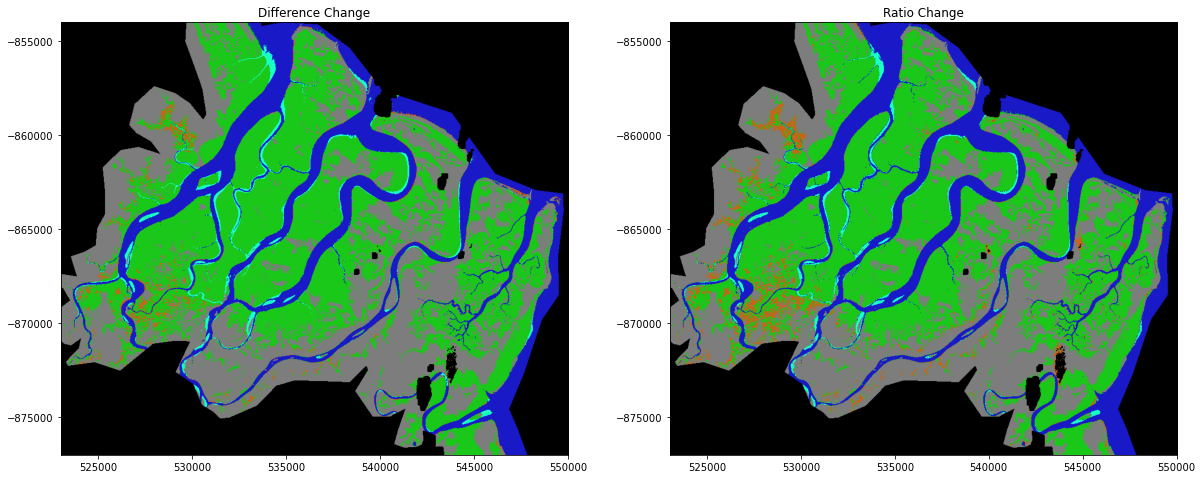

In [23]:
sub_bbox = [523000, 550000, -877000, -854000]


# Get the image data using the get_gdal_thematic_raster_mpl_imshow function.
(
    img_diff_msk_data,
    img_diff_msk_coords,
    lgd_diff_msk_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    chng_map_diff_img, bbox=sub_bbox
)


(
    img_ratio_msk_data,
    img_ratio_msk_coords,
    lgd_ratio_msk_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    chng_map_ratio_img, bbox=sub_bbox
)

# Create the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))


ax1.imshow(img_diff_msk_data, extent=img_diff_msk_coords)
ax1.set_title("Difference Change")

ax2.imshow(img_ratio_msk_data, extent=img_ratio_msk_coords)
ax2.set_title("Ratio Change")

## Observations of the results

What you can probably see looking at the two change classifications is that the ratio based change has been more sensitive to the loss of mangrove than the different base change. However, for the gain of mangroves from water it would appear the sensitivity is pretty similar.
